# BERTopic + HDBScan

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [58]:
conn = sqlite3.connect(r'E:\SynologyDrive\ironhack\week_14\day_2\project-nlp-business-case-automated-customers-reviews-v2\data\gamesDB.db')
query = 'select reviews.review, reviews.voted_up, reviews.weighted_vote_score, reviews_with_topics.topic_name from reviews INNER JOIN reviews_with_topics ON reviews.recommendationid = reviews_with_topics.recommendationid;'
df = pd.read_sql_query(query, conn)
conn.close()

In [59]:
df['voted_up'].value_counts()

voted_up
1    56376
0    25147
Name: count, dtype: int64

### Topic frequency

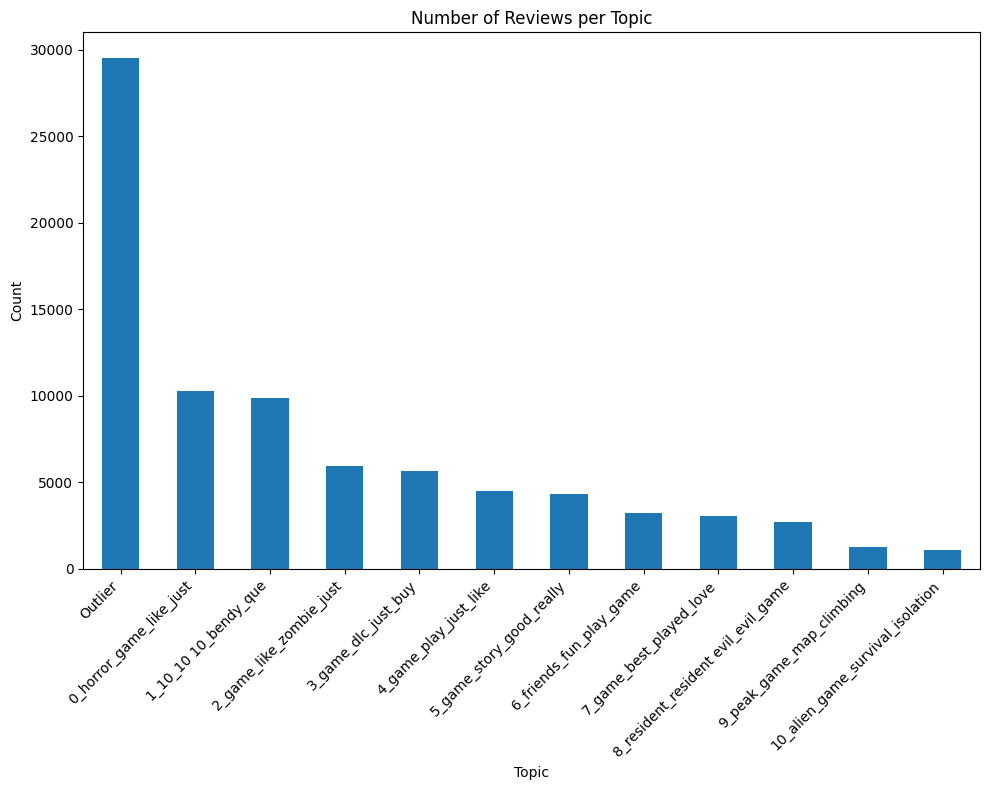

In [8]:
topic_counts = df["topic_name"].value_counts()
plt.figure(figsize=(10, 8))
topic_counts.plot(kind="bar")
plt.title("Number of Reviews per Topic")
plt.ylabel("Count")
plt.xlabel("Topic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Topic coverage vs Outliers

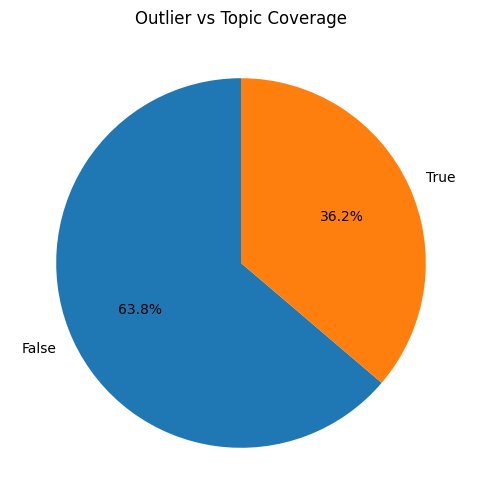

In [9]:
df["is_outlier"] = df["topic_name"] == "Outlier"
coverage = df["is_outlier"].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
coverage.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Outlier vs Topic Coverage")
plt.ylabel("")
plt.show()


30–35% Outliers → red flag

### Score distribution by topic

In [40]:
import numpy as np

In [42]:
# Exponential
wide_data = np.exp(df['weighted_vote_score'])

In [43]:
wide_data

0        1.648721
1        1.648721
2        1.648721
3        1.648721
4        1.924715
           ...   
81518    1.716401
81519    1.659032
81520    1.609930
81521    1.694790
81522    1.684955
Name: weighted_vote_score, Length: 81523, dtype: float64

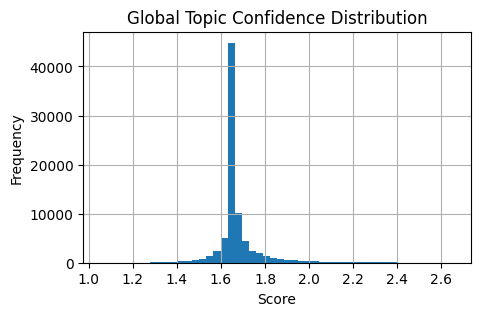

In [47]:
plt.figure(figsize=(5, 3))
wide_data.hist(bins=50)
plt.title("Global Topic Confidence Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

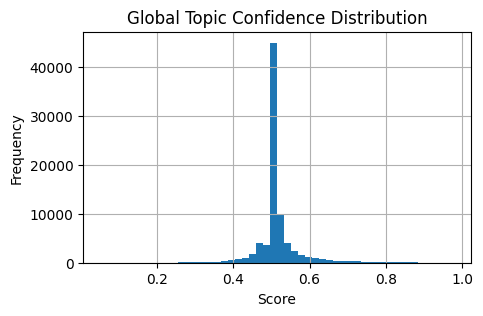

In [48]:
plt.figure(figsize=(5, 3))
df['weighted_vote_score'].hist(bins=50)
plt.title("Global Topic Confidence Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

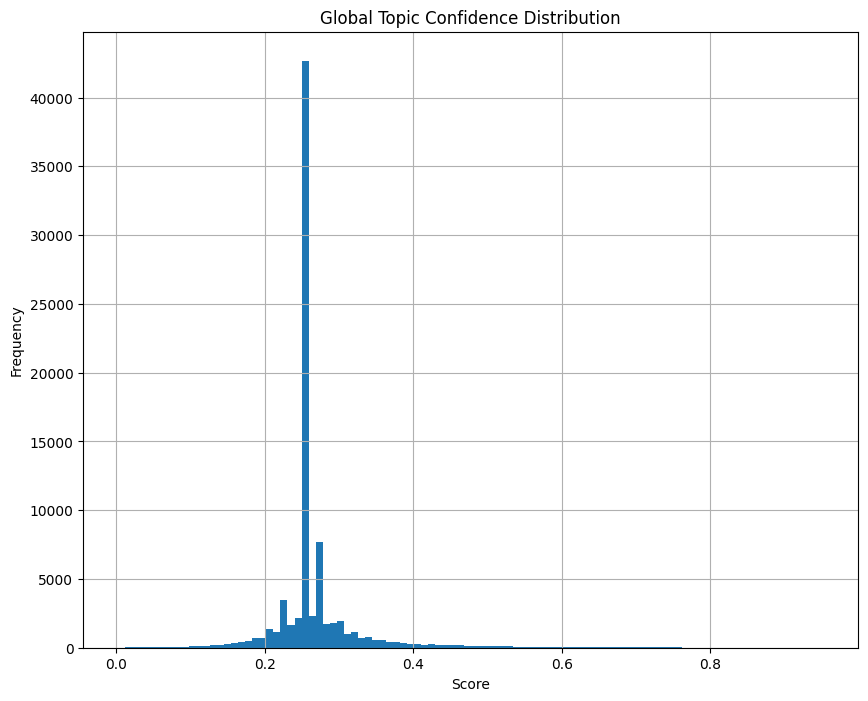

In [54]:
def power_transform_centered(data, power=3):
    return np.sign(data) * np.abs(data) ** power

wide_data = power_transform_centered(df['weighted_vote_score'], power=2)
plt.figure(figsize=(10, 8))
wide_data.hist(bins=100)
plt.title("Global Topic Confidence Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [55]:
df['weighted_power'] = wide_data

<Figure size 800x600 with 0 Axes>

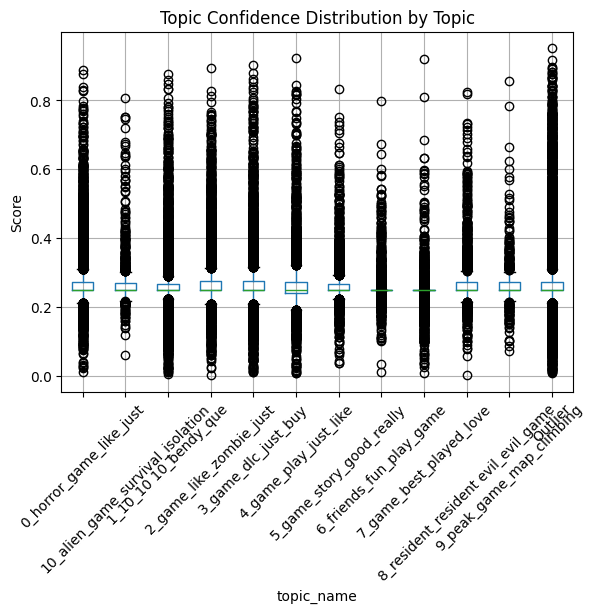

In [56]:
plt.figure(figsize=(8, 6))
df.boxplot(column="weighted_power", by="topic_name", rot=45)
plt.title("Topic Confidence Distribution by Topic")
plt.suptitle("")
plt.ylabel("Score")
plt.show()

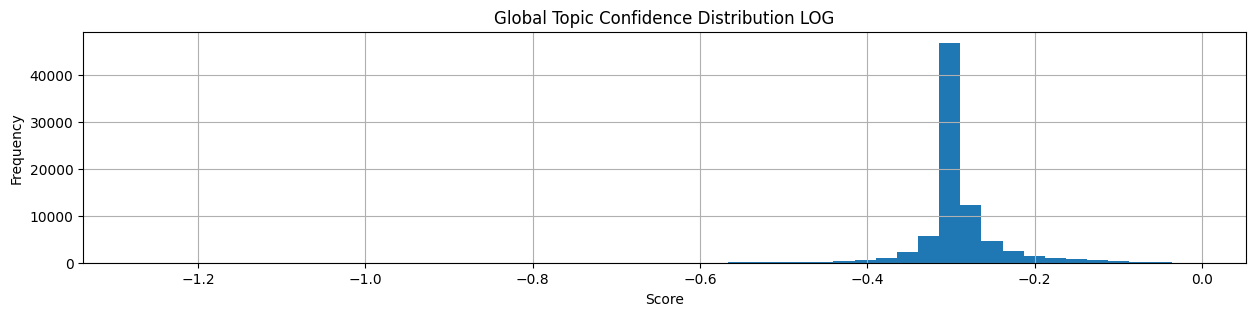

In [68]:
wide_data_log = np.log10(df['weighted_vote_score'])
plt.figure(figsize=(15, 3))
wide_data_log.hist(bins=50)
plt.title("Global Topic Confidence Distribution LOG")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [62]:
df['weighted_log'] = wide_data_log

<Figure size 2600x1800 with 0 Axes>

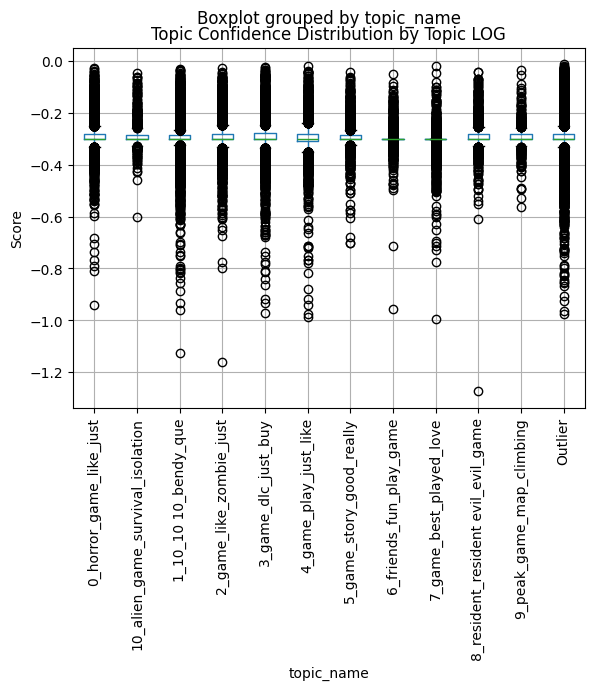

In [67]:
plt.figure(figsize=(26, 18))
df.boxplot(column="weighted_log", by="topic_name", rot=90)
plt.title("Topic Confidence Distribution by Topic LOG")
plt.ylabel("Score")
plt.show()

Scores clustered around 0.5 → weak separation

### Score distribution by topic

<Figure size 800x600 with 0 Axes>

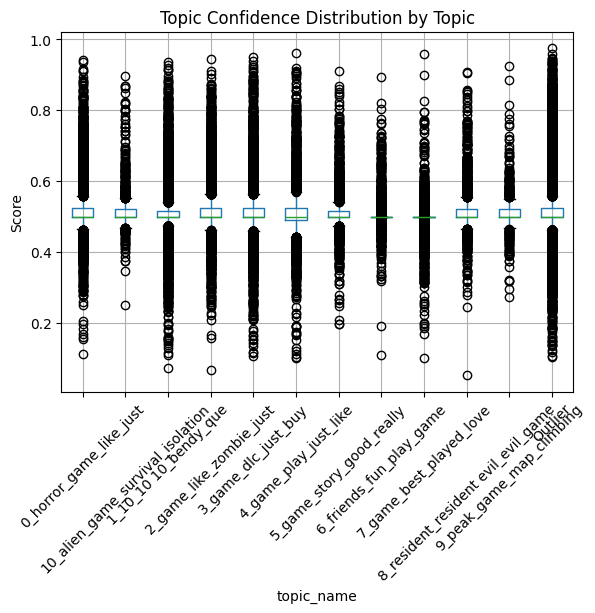

In [25]:
plt.figure(figsize=(8, 6))
df.boxplot(column="weighted_vote_score", by="topic_name", rot=45)
plt.title("Topic Confidence Distribution by Topic")
plt.suptitle("")
plt.ylabel("Score")
plt.show()

Topics with higher medians = better defined

Topics overlapping with Outlier = questionable

### Topic frequency

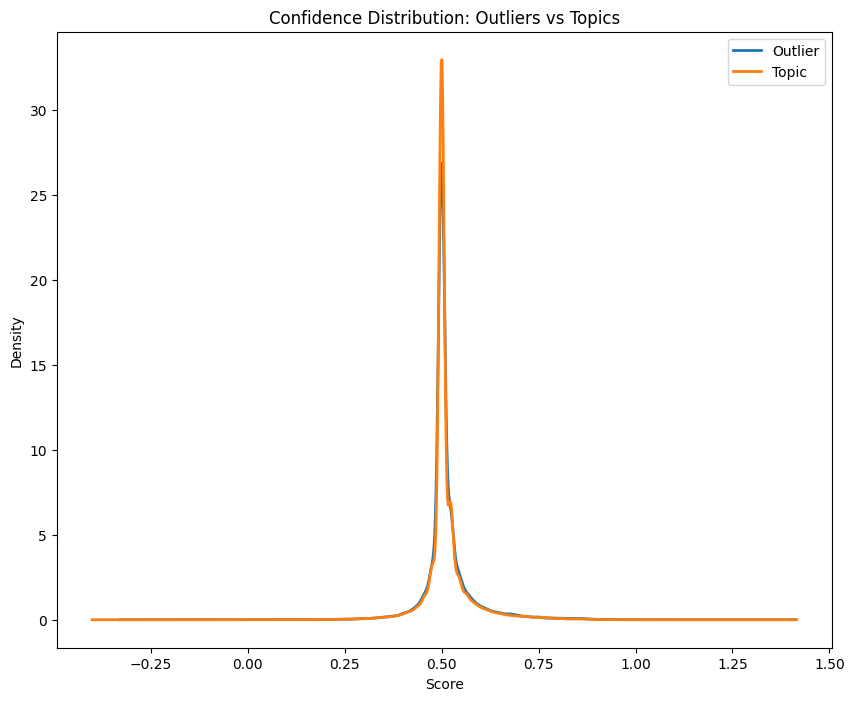

In [27]:
plt.figure(figsize=(10, 8))

df[df["is_outlier"]]["weighted_vote_score"].plot(
    kind="kde", label="Outlier", linewidth=2
)
df[~df["is_outlier"]]["weighted_vote_score"].plot(
    kind="kde", label="Topic", linewidth=2
)

plt.title("Confidence Distribution: Outliers vs Topics")
plt.xlabel("Score")
plt.legend()
plt.show()

Heavy overlap → threshold is arbitrary

Clear separation → outlier labeling is meaningful

### Confidence threshold analysis

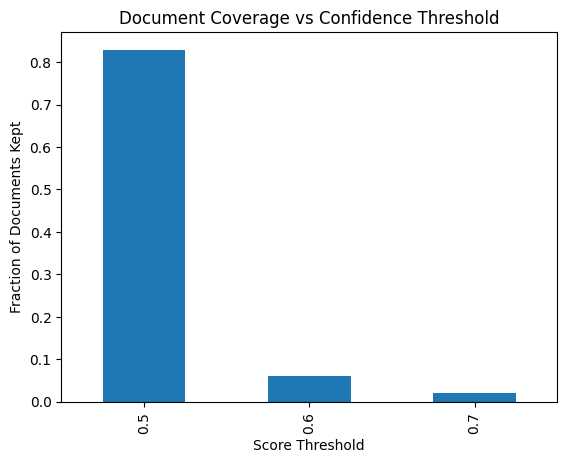

In [28]:
thresholds = [0.5, 0.6, 0.7]
coverage = {
    t: (df["weighted_vote_score"] >= t).mean()
    for t in thresholds
}

pd.Series(coverage).plot(kind="bar")
plt.title("Document Coverage vs Confidence Threshold")
plt.ylabel("Fraction of Documents Kept")
plt.xlabel("Score Threshold")
plt.show()

If coverage collapses fast → model is weak

Helps justify filtering in reports

### Topic size vs confidence

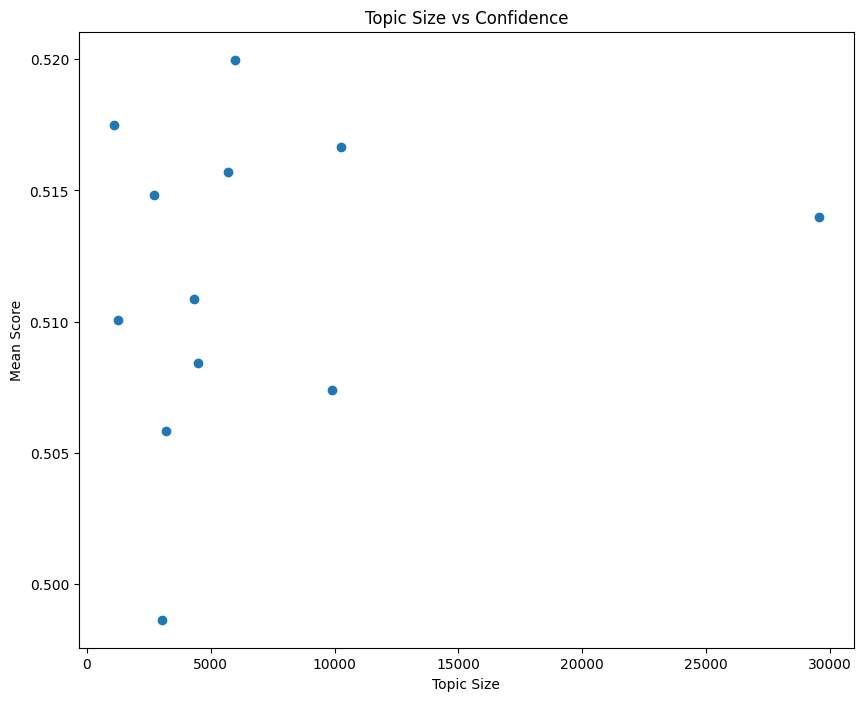

In [29]:
topic_stats = df.groupby("topic_name").agg(
    count=("weighted_vote_score", "size"),
    mean_score=("weighted_vote_score", "mean")
)

plt.figure(figsize=(10, 8))
plt.scatter(topic_stats["count"], topic_stats["mean_score"])
plt.xlabel("Topic Size")
plt.ylabel("Mean Score")
plt.title("Topic Size vs Confidence")
plt.show()


Big + low score → garbage topic

Small + high score → niche but meaningful

# CountVectorizer + LDA

In [90]:
conn = sqlite3.connect(r'E:\SynologyDrive\ironhack\week_14\day_2\nlp-business-case-automated-customers-reviews\data\raw\gamesDB.db')
query = 'select reviews.review, reviews.weighted_vote_score, lda_topics_7.topic from reviews INNER JOIN lda_topics_7 ON reviews.recommendationid = lda_topics_7.recommendationid;'
df_lda = pd.read_sql_query(query, conn)
conn.close()

### Topic frequency

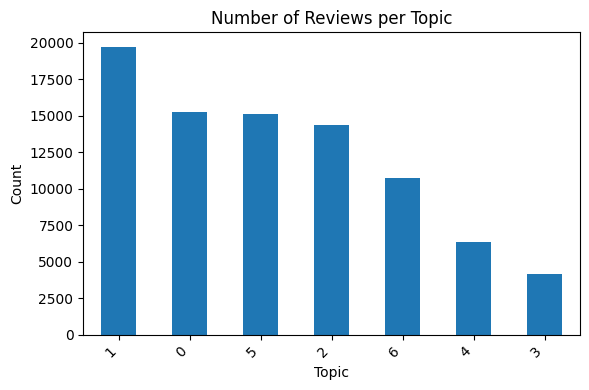

In [91]:
topic_counts = df_lda["topic"].value_counts()
plt.figure(figsize=(6, 4))
topic_counts.plot(kind="bar")
plt.title("Number of Reviews per Topic")
plt.ylabel("Count")
plt.xlabel("Topic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

One dominant bar → topic collapse

### Global score distribution

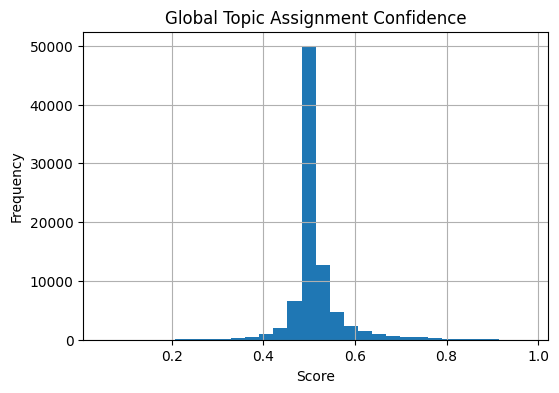

In [92]:
plt.figure(figsize=(6, 4))
df_lda["weighted_vote_score"].hist(bins=30)
plt.title("Global Topic Assignment Confidence")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

### Boxplot of score per topic

<Figure size 800x600 with 0 Axes>

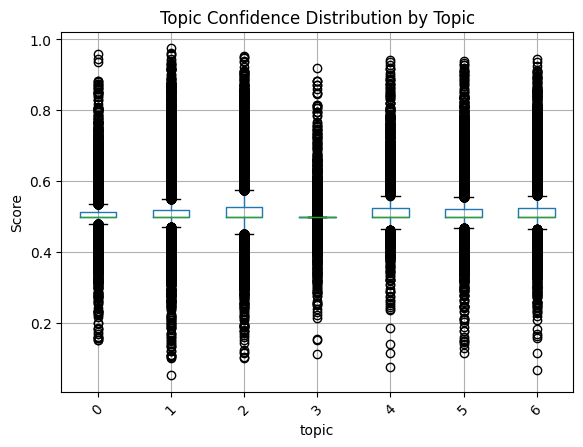

In [93]:
plt.figure(figsize=(8, 6))
df_lda.boxplot(column="weighted_vote_score", by="topic", rot=45)
plt.title("Topic Confidence Distribution by Topic")
plt.suptitle("")
plt.ylabel("Score")
plt.show()

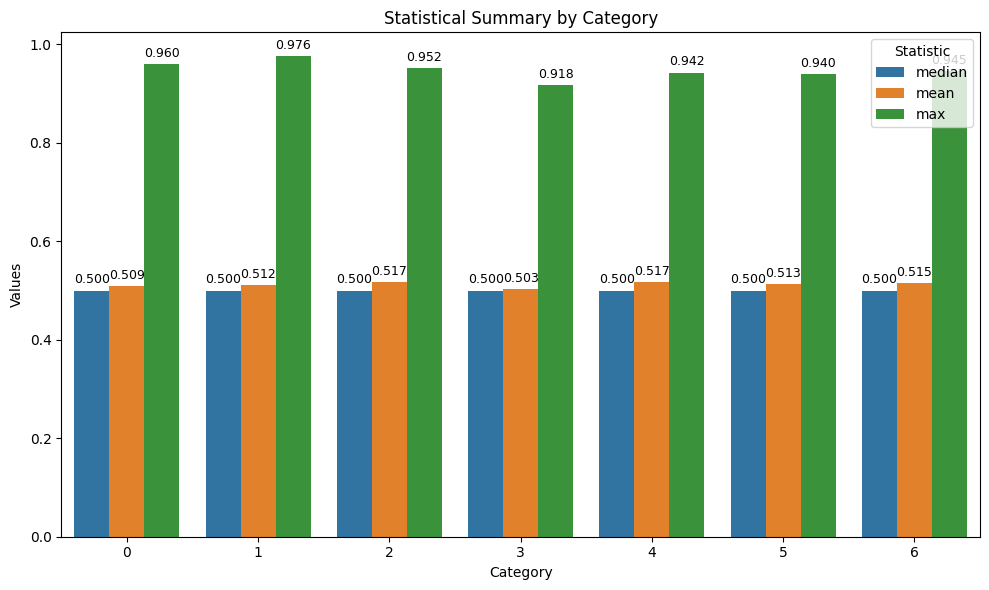

In [100]:
import seaborn as sns
stats = df_lda.groupby('topic')['weighted_vote_score'].agg(['median', 'mean', 'max']).reset_index()
# Reshape data for seaborn
stats_melted = stats.melt(id_vars='topic', 
                          value_vars=['median', 'mean', 'max'],
                          var_name='statistic', 
                          value_name='value')

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=stats_melted, x='topic', y='value', hue='statistic', ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('Statistical Summary by Category')
ax.legend(title='Statistic')

plt.tight_layout()
plt.show()

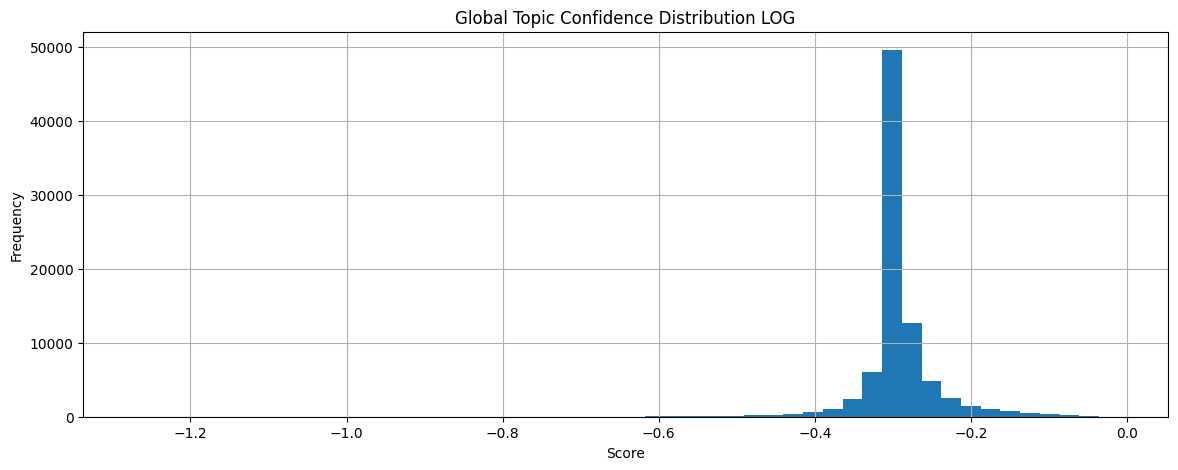

In [99]:
wide_data_log = np.log10(df_lda['weighted_vote_score'])
plt.figure(figsize=(14, 5))
wide_data_log.hist(bins=50)
plt.title("Global Topic Confidence Distribution LOG")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

### Zero-shot

In [119]:
conn = sqlite3.connect(r'E:\SynologyDrive\ironhack\week_14\day_2\nlp-business-case-automated-customers-reviews\data\raw\gamesDB.db')
query = 'select * from reviews_zeroshot;'
df_zero = pd.read_sql_query(query, conn)
conn.close()

In [120]:
topic_columns = df_zero.columns[-6:]

<Axes: xlabel='best_topic'>

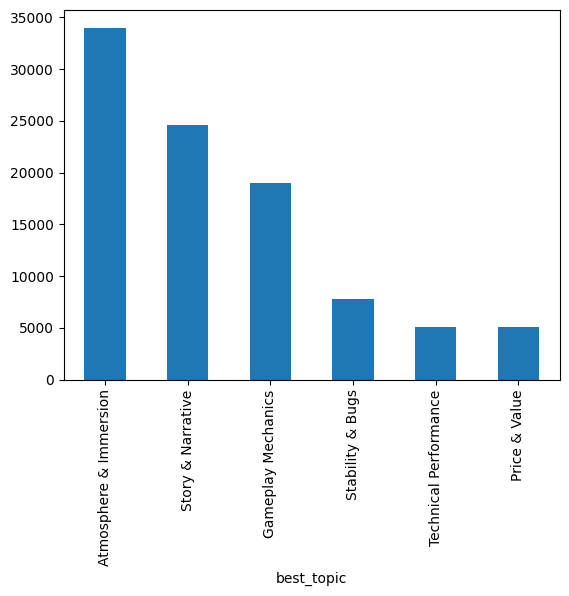

In [148]:
df_zero['best_topic'].value_counts().plot(kind='bar')

In [121]:
df_zero['best_topic'] = df_zero[topic_columns].idxmax(axis=1)

D:\Systemp\ipykernel_9360\3833844400.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_zero['best_topic'] = df_zero[topic_columns].idxmax(axis=1)


In [125]:
df_zero['best_topic'].apply(type).value_counts()

best_topic
<class 'str'>      100072
<class 'float'>       135
Name: count, dtype: int64

In [132]:
df_float = df_zero[df_zero["best_topic"].apply(lambda x: isinstance(x, float))]

In [136]:
df_zero.dropna(inplace=True)

In [139]:
df_zero['best_topic'] = df_zero['best_topic'].apply(lambda x: x.split('_')[-1])

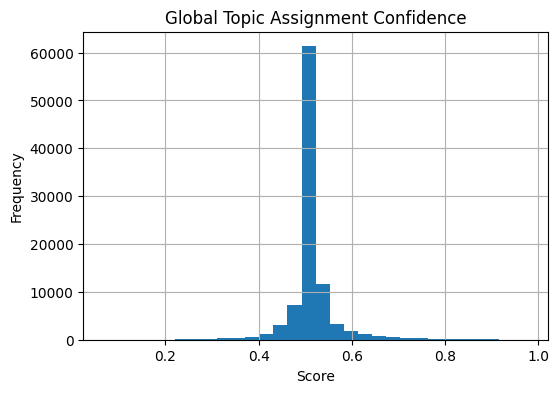

In [144]:
plt.figure(figsize=(6, 4))
df_zero["weighted_vote_score"].hist(bins=30)
plt.title("Global Topic Assignment Confidence")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

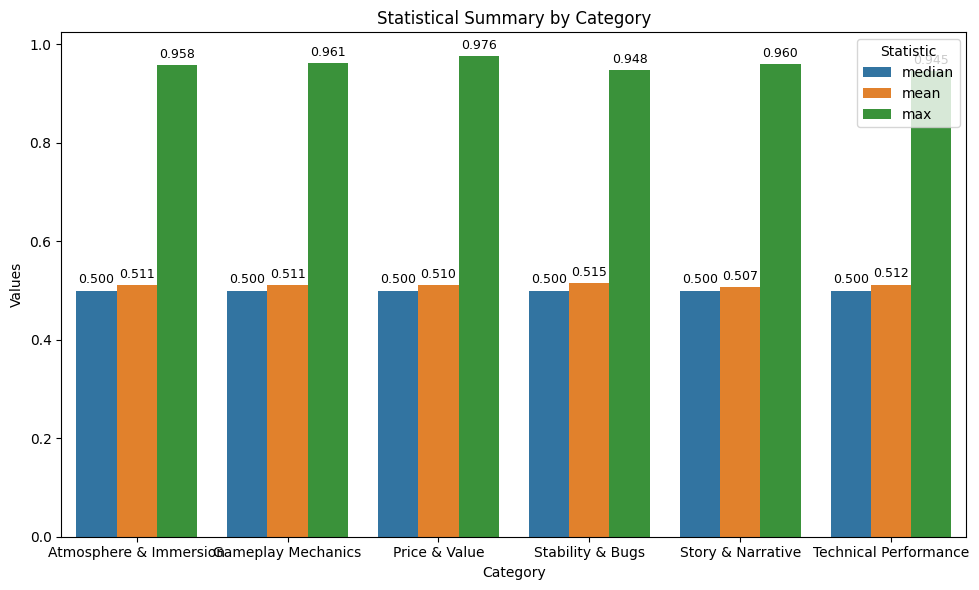

In [146]:
import seaborn as sns
stats = df_zero.groupby('best_topic')['weighted_vote_score'].agg(['median', 'mean', 'max']).reset_index()
# Reshape data for seaborn
stats_melted = stats.melt(id_vars='best_topic', 
                          value_vars=['median', 'mean', 'max'],
                          var_name='statistic', 
                          value_name='value')

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=stats_melted, x='best_topic', y='value', hue='statistic', ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('Statistical Summary by Category')
ax.legend(title='Statistic')

plt.tight_layout()
plt.show()

In [150]:
df_zero['appid'].sample(n=5)

17714    2497920
47569    2050650
77203    1929610
21396     238320
81930    2947440
Name: appid, dtype: int64